# Heritability estimate on subtype from social activation maps

##### Subtype:
- Niak preprocessed SOCIAL task (new scrub method)
- 5 subtype
- **FD_scrubbed_mean regressed out befor building subtypes**

##### Heritability:
- Regress "FD_scrubbed_mean" "Age_in_Yrs" "Gender" as covariate


## Build Pheno file

### Merge behavioral variables with subtypes weights

In [1]:
# Import pandas
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set_style("whitegrid")

In [3]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
# Set up the paths 
path_root = '/media/yassine/data_disk/Drive/HCP2/'
#path_root = "/home/yassinebha/Drive/HCP/"
subt_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_SOCIAL_18-Oct-2017/")
net_path = os.path.join(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_SOCIAL_18-Oct-2017/networks/")
out_path = os.path.join(path_root,"Solar_heritability/HCP_subtype/")

In [5]:
nb_sbt = natural_keys(subt_path)[9]
# task name
task_name = natural_keys(subt_path)[10][5:-1].lower()

In [6]:
task_name

'social'

In [7]:
# Set up files name
sbt_name_pattern = "sbt_weights_net_{}.csv"
pheno_path = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno/hcp_pheno_{}_raw.csv".format(task_name))
solar_script = 'fcd_solar_h2r_test.sh'
pheno_save = 'solar_{}_spm_{}_pheno.csv'.format(task_name.upper(),nb_sbt)
pedig_save = 'solar_{}_spm_pedigre.csv'.format(task_name.upper())
solar_out = 'subtype_{}_{}_{}'.format(nb_sbt,task_name,time.strftime("%d-%m-%Y"))
h2r_out_file = 'h2r_solar_{}_spm_{}.csv'
## Solar covariates
solar_cov = '    cov {}_FD_scrubbed_mean Gender'.format(task_name[:3].upper())

In [8]:
# List of network names
list_trial = os.listdir(net_path)
list_trial

['mental', 'contrast_mental_vs_rnd']

In [27]:
# Loop over each network and build weight file
for index, trial_name in enumerate(list_trial):
    file_path = os.path.join(net_path, trial_name, sbt_name_pattern.format(trial_name))
    if not os.path.exists(file_path):
        print("Hello, {} does not exist".format(file_path))
    
    tmp_weights = pd.read_csv(file_path)
    # Rename first column
    tmp_weights.rename(columns={" ":"Subject"}, inplace=True)
    tmp_weights.Subject = tmp_weights.Subject.str.strip(" ")
    
    rename_dict = dict()
    for colname in tmp_weights.columns:
        if colname == "Subject":
            continue
        else:
            new_name = "{}_{}_{}".format(task_name[:3].upper(),trial_name, colname)
            # Get rid of trailing whitespace
            new_name = new_name.strip(" ")
            rename_dict[colname] = new_name

    tmp_weights.rename(columns=rename_dict, inplace=True)
    
    if index==0:
        dataframe = tmp_weights
    else:
        dataframe = pd.merge(dataframe, tmp_weights, on="Subject", how="inner")

In [28]:
dataframe.head()

,Subject,SOC_mental_sub1,SOC_mental_sub2,SOC_mental_sub3,SOC_mental_sub4,SOC_mental_sub5,SOC_contrast_mental_vs_rnd_sub1,SOC_contrast_mental_vs_rnd_sub2,SOC_contrast_mental_vs_rnd_sub3,SOC_contrast_mental_vs_rnd_sub4,SOC_contrast_mental_vs_rnd_sub5
0,HCP100206,-0.140,-0.093,-0.241,0.138,0.261,-0.181,0.183,0.201,-0.124,-0.067
1,HCP100307,0.385,0.049,0.621,-0.466,-0.612,0.456,-0.015,-0.391,0.123,-0.328
2,HCP100408,-0.141,0.110,-0.154,0.076,0.157,-0.286,0.120,0.288,-0.153,0.112
3,HCP100610,0.273,0.180,0.196,-0.318,-0.244,-0.014,-0.110,-0.104,0.257,-0.104
4,HCP101006,0.307,0.046,0.189,-0.226,-0.251,0.022,0.156,0.033,-0.177,-0.013


In [29]:
dataframe.Subject.describe()

count           784
unique          784
top       HCP735148
freq              1
Name: Subject, dtype: object

In [30]:
# Load pheno file
file_weight = dataframe
file_pheno = pd.read_csv(pheno_path)

In [31]:
file_pheno.head()

,Unnamed: 0,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,FD_scrubbed_mean,FD_mean,Subject,Age_in_Yrs,Gender,...,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,HCP100206,0.084949,0.084949,0.096656,0.096656,0.090803,0.090803,HCP100206,27.0,1.0,...,-0.344595,1.283574,0.052662,1.436342,0.706008,-0.510366,1.975280,1.294323,-0.025888,-0.203825
1,HCP100307,0.098119,0.098119,0.087372,0.087372,0.092746,0.092746,HCP100307,27.0,2.0,...,-0.639736,0.522789,-0.952467,-0.713226,-0.559144,-0.140952,-0.703027,0.229112,0.097581,-0.444702
2,HCP100408,0.103292,0.103292,0.135210,0.135210,0.119251,0.119251,HCP100408,33.0,1.0,...,1.173656,0.092160,-0.521888,-0.034026,-0.109229,0.221359,-0.589268,0.357483,-0.039443,0.095913
3,HCP100610,0.179657,0.179657,0.189551,0.189551,0.184604,0.184604,HCP100610,27.0,1.0,...,0.891096,-0.361182,-0.881930,-0.386394,-0.575076,-0.197974,0.203063,0.618868,0.491618,1.343114
4,HCP101006,0.145925,0.145925,0.124287,0.124287,0.135106,0.135106,HCP101006,35.0,2.0,...,0.608381,0.037740,0.055531,-0.883482,-0.383174,-0.309221,-0.753780,-1.183212,0.031989,-0.494022


In [32]:
file_pheno.Subject.describe()

count           803
unique          803
top       HCP871964
freq              1
Name: Subject, dtype: object

In [33]:
# Select a subset of variable
file_pheno_subset = file_pheno[["Subject","Age_in_Yrs","Gender","BMI","FD_mean","FD_scrubbed_mean"]]
file_pheno_subset.rename(columns={'FD_mean': '{}_FD_mean'.format(task_name[:3].upper()),
                                  'FD_scrubbed_mean': '{}_FD_scrubbed_mean'.format(task_name[:3].upper())},
                         inplace=True)
file_pheno_subset.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


,Subject,Age_in_Yrs,Gender,BMI,SOC_FD_mean,SOC_FD_scrubbed_mean
0,HCP100206,27.0,1.0,26.64,0.090803,0.090803
1,HCP100307,27.0,2.0,22.96,0.092746,0.092746
2,HCP100408,33.0,1.0,27.75,0.119251,0.119251
3,HCP100610,27.0,1.0,36.91,0.184604,0.184604
4,HCP101006,35.0,2.0,30.27,0.135106,0.135106


In [34]:
# Replace gender M=1 and F=2
#file_pheno_subset.Gender.replace({'M':1,'F':2}, inplace=True)
#file_pheno_subset.head()

In [35]:
file_pheno_subset[["Subject"]].describe()

,Subject
count,803
unique,803
top,HCP871964
freq,1


In [36]:
file_weight[["Subject"]].describe()

,Subject
count,784
unique,784
top,HCP735148
freq,1


In [37]:
# Merge weight with subset of pheno variables
merged_weight_pheno = pd.merge(file_weight, file_pheno_subset, on='Subject', how='left')
# Replace 'Subject' by 'ID'
merged_weight_pheno.rename(columns={'Subject':'ID'},inplace=True)
merged_weight_pheno.head()

,ID,SOC_mental_sub1,SOC_mental_sub2,SOC_mental_sub3,SOC_mental_sub4,SOC_mental_sub5,SOC_contrast_mental_vs_rnd_sub1,SOC_contrast_mental_vs_rnd_sub2,SOC_contrast_mental_vs_rnd_sub3,SOC_contrast_mental_vs_rnd_sub4,SOC_contrast_mental_vs_rnd_sub5,Age_in_Yrs,Gender,BMI,SOC_FD_mean,SOC_FD_scrubbed_mean
0,HCP100206,-0.140,-0.093,-0.241,0.138,0.261,-0.181,0.183,0.201,-0.124,-0.067,27.0,1.0,26.64,0.090803,0.090803
1,HCP100307,0.385,0.049,0.621,-0.466,-0.612,0.456,-0.015,-0.391,0.123,-0.328,27.0,2.0,22.96,0.092746,0.092746
2,HCP100408,-0.141,0.110,-0.154,0.076,0.157,-0.286,0.120,0.288,-0.153,0.112,33.0,1.0,27.75,0.119251,0.119251
3,HCP100610,0.273,0.180,0.196,-0.318,-0.244,-0.014,-0.110,-0.104,0.257,-0.104,27.0,1.0,36.91,0.184604,0.184604
4,HCP101006,0.307,0.046,0.189,-0.226,-0.251,0.022,0.156,0.033,-0.177,-0.013,35.0,2.0,30.27,0.135106,0.135106


In [38]:
merged_weight_pheno.ID.describe()

count           784
unique          784
top       HCP735148
freq              1
Name: ID, dtype: object

In [39]:
# Check if there is empty value in BMI
sum(merged_weight_pheno.BMI.isnull())

0

In [40]:
# Save the merged file
merged_weight_pheno.to_csv(os.path.join(out_path,pheno_save), index=False)

In [41]:
os.path.join(out_path,pheno_save)

'/media/yassine/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/solar_SOCIAL_spm_5_pheno.csv'

## Build trait file

In [42]:
## build trait file
# Remove not neaded traits
list_trait = merged_weight_pheno.columns.tolist()
new_list = [trait for trait in list_trait if trait not in ['ID','Age_in_Yrs','Gender']]
new_list

['SOC_mental_sub1',
 'SOC_mental_sub2',
 'SOC_mental_sub3',
 'SOC_mental_sub4',
 'SOC_mental_sub5',
 'SOC_contrast_mental_vs_rnd_sub1',
 'SOC_contrast_mental_vs_rnd_sub2',
 'SOC_contrast_mental_vs_rnd_sub3',
 'SOC_contrast_mental_vs_rnd_sub4',
 'SOC_contrast_mental_vs_rnd_sub5',
 'BMI',
 'SOC_FD_mean',
 'SOC_FD_scrubbed_mean']

In [43]:
# Save trait file
file_out = open(os.path.join(out_path,"trait_file"), 'w')
for item in new_list:
    file_out.write("%s\n" % item)
file_out.close()

## Build Pedigree file

In [44]:
# Select a subset of variable from pheno file
file_pheno_pedig = file_pheno[["Subject","Twin_Stat","Zygosity","Mother_ID","Gender"]]
file_pheno_pedig.head()

,Subject,Twin_Stat,Zygosity,Mother_ID,Gender
0,HCP100206,NotTwin,NotTwin,56037.0,1.0
1,HCP100307,Twin,NotMZ,51488.0,2.0
2,HCP100408,Twin,MZ,51730.0,1.0
3,HCP100610,Twin,NotMZ,52813.0,1.0
4,HCP101006,Twin,MZ,51283.0,2.0


In [45]:
file_pheno_pedig.Subject.describe()

count           803
unique          803
top       HCP871964
freq              1
Name: Subject, dtype: object

In [46]:
# Build pedigre : ID , mo, fo, hhID, mztwins,sex
mother_id = ["mo_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
father_id = ["fa_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
household_id = ["hh_{}".format(row.Mother_ID) for ind, row in file_pheno_pedig.iterrows()]
twin_id = ["pair_{}".format(row.Mother_ID) if row.Zygosity == "MZ" else "" for ind, row in file_pheno_pedig.iterrows()]

In [47]:
# write into new data frame
df_pedig = pd.DataFrame()
df_pedig["ID"] = file_pheno_pedig.Subject
df_pedig["fa"] = father_id
df_pedig["mo"] = mother_id
df_pedig["sex"] = file_pheno_pedig.Gender.astype(int)
df_pedig["mztwin"] = twin_id
df_pedig["hhID"] = household_id


print("head")
display(df_pedig.head())
print("tail")
display(df_pedig.tail())
df_pedig.count()

head


,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


tail


,ID,fa,mo,sex,mztwin,hhID
798,HCP992673,fa_56143.0,mo_56143.0,2,,hh_56143.0
799,HCP992774,fa_51345.0,mo_51345.0,1,,hh_51345.0
800,HCP993675,fa_55800.0,mo_55800.0,2,,hh_55800.0
801,HCP994273,fa_52364.0,mo_52364.0,1,,hh_52364.0
802,HCP996782,fa_51541.0,mo_51541.0,2,,hh_51541.0


ID        803
fa        803
mo        803
sex       803
mztwin    803
hhID      803
dtype: int64

In [48]:
# Look for MZ twins missing their co-twin
uniques = list(df_pedig.mztwin.unique())
uniques.pop(0)
twin_counts = [np.sum(df_pedig.mztwin==twin) for twin in uniques]
#for idx, twin in enumerate(uniques):
    #print("{} occurs {} times".format(twin, twin_counts[idx]))

In [49]:
# create a mask that will kepp only MZ twins missing their co-twin
singles = [True if np.sum(df_pedig.mztwin==row.mztwin)==1 else False for ind, row in df_pedig.iterrows()]

In [50]:
# Make a copy of the pedigre to avoid missing up with the original data
copy_df_pedig = df_pedig.copy()

In [51]:
# Select only MZ twins missing their co-twin
df_single_pedig = copy_df_pedig[singles]

# Add "M_" (for missing) to a the single MZ twins
for i, row in df_single_pedig.iterrows():
    df_single_pedig.set_value(i,"ID","M_{}".format(row.ID))
display(df_single_pedig.head())
df_single_pedig.count()

,ID,fa,mo,sex,mztwin,hhID
37,M_HCP110007,fa_54572.0,mo_54572.0,2,pair_54572.0,hh_54572.0
55,M_HCP114823,fa_52925.0,mo_52925.0,2,pair_52925.0,hh_52925.0
82,M_HCP122317,fa_51802.0,mo_51802.0,1,pair_51802.0,hh_51802.0
87,M_HCP123824,fa_56022.0,mo_56022.0,1,pair_56022.0,hh_56022.0
90,M_HCP124422,fa_51529.0,mo_51529.0,2,pair_51529.0,hh_51529.0


ID        40
fa        40
mo        40
sex       40
mztwin    40
hhID      40
dtype: int64

In [52]:
# Append pedgree with fake co-twin for the missing one
df_pedig_final = copy_df_pedig.append(df_single_pedig)
df_pedig_final.head()

,ID,fa,mo,sex,mztwin,hhID
0,HCP100206,fa_56037.0,mo_56037.0,1,,hh_56037.0
1,HCP100307,fa_51488.0,mo_51488.0,2,,hh_51488.0
2,HCP100408,fa_51730.0,mo_51730.0,1,pair_51730.0,hh_51730.0
3,HCP100610,fa_52813.0,mo_52813.0,1,,hh_52813.0
4,HCP101006,fa_51283.0,mo_51283.0,2,pair_51283.0,hh_51283.0


In [53]:
df_pedig_final.tail()

,ID,fa,mo,sex,mztwin,hhID
695,M_HCP769064,fa_52803.0,mo_52803.0,1,pair_52803.0,hh_52803.0
722,M_HCP835657,fa_52137.0,mo_52137.0,2,pair_52137.0,hh_52137.0
724,M_HCP837964,fa_52875.0,mo_52875.0,2,pair_52875.0,hh_52875.0
766,M_HCP904044,fa_51290.0,mo_51290.0,2,pair_51290.0,hh_51290.0
790,M_HCP972566,fa_56077.0,mo_56077.0,2,pair_56077.0,hh_56077.0


In [54]:
df_pedig_final.count()

ID        843
fa        843
mo        843
sex       843
mztwin    843
hhID      843
dtype: int64

In [55]:
# Save the pedigree file
df_pedig_final.to_csv(os.path.join(out_path,pedig_save), index=False)

## Run SOLAR heritability estimate 

In [56]:
%%bash -s "$out_path" "$solar_cov" "$solar_script" 
cd $1 #cd to out_path
#sufix=$(echo $2 | sed -e 's/ /_/g') # add a suffix of covariate
sed -i "104s/.*/$2/" $3 # feed the covariate to solar script
sed -i "52s~.*~$1phi2.gz~" $3 # put the right path for the simlink
sed -i "53s~.*~$1pedindex.out~" $3
sed -i "54s~.*~$1pedindex.cde~" $3
sed -i "55s~.*~$1se_univ_polygen.tcl~" $3

In [57]:
%%bash -s "$out_path" "$pedig_save"
cd $1
solar <<INTERNAL_SOLAR_SCRIPT  
load pedi $2
pedigree classes -full
INTERNAL_SOLAR_SCRIPT


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Unloading current pedigree data ...
Loading pedigree data from the file solar_SOCIAL_spm_pedigre.csv ...
::::::::::::::
mibdrel.tab
::::::::::::::

    NPairs  Relationship
  ========  ===========================================
      1571  Self
       116  Identical sib pair
      1686  Parent-offspring
       592  Siblings
       364  Unrelated



In [58]:
%%bash -s "$out_path" "$pheno_save" "$solar_out"
cd $1
#if [ ! -d $3 ]; then
#   mkdir $3
#fi
solar <<INTERNAL_SOLAR_SCRIPT 
load pheno $2
INTERNAL_SOLAR_SCRIPT
bash fcd_solar_h2r_test.sh trait_file $3 $1$2
for i in $3/Set-*; do bash $i/run_all.sh ; done


SOLAR Eclipse version 8.1.1 (General), last updated on December 12, 2017
Copyright (c) 1995-2017 Texas Biomedical Research Institute
Enter help for help, exit to exit, doc to browse documentation.

Creating output directories...
00012 : Set-12 : SOC_FD_scrubbed_mean                                                  
All done.


## Results

In [9]:
solar_out = 'subtype_5_social_23-01-2018'
out_herit = pd.read_csv(os.path.join(out_path,solar_out,"se_out.out"),sep="\t",header=None)
out_herit_df =  pd.DataFrame()

data = pd.DataFrame({"Trait": out_herit[2],"H2r": out_herit[4],"P": out_herit[7],"CovVarianceExpl": out_herit[9]})
out_herit_df = data[["Trait","H2r","P","CovVarianceExpl"]].sort_values(['Trait'], ascending=[True]).reset_index(drop=True)
out_herit_df

,Trait,H2r,P,CovVarianceExpl
0,BMI_norm,0.542517,1.209626e-12,0.393134
1,SOC_FD_mean_norm,0.303006,6.490000e-05,0.790161
2,SOC_FD_scrubbed_mean_norm,0.053441,2.178340e-01,0.935168
3,SOC_contrast_mental_vs_rnd_sub1_norm,0.390694,1.399991e-08,0.002414
4,SOC_contrast_mental_vs_rnd_sub2_norm,0.202039,1.698000e-03,0.000456
5,SOC_contrast_mental_vs_rnd_sub3_norm,0.289739,3.860000e-05,0.000869
6,SOC_contrast_mental_vs_rnd_sub4_norm,0.108292,5.952560e-02,0.000282
7,SOC_contrast_mental_vs_rnd_sub5_norm,0.565559,7.771668e-19,0.001359
8,SOC_mental_sub1_norm,0.575279,1.224577e-17,0.000035
9,SOC_mental_sub2_norm,0.440498,2.848080e-09,0.011343


In [10]:
# remove unwanted Variables
out_herit_df_clean = out_herit_df[~out_herit_df['Trait'].str.strip().isin(['BMI_norm',
                                                                           '{}_FD_mean_norm'.format(task_name[:3].upper()),
                                                                           '{}_FD_scrubbed_mean_norm'.format(task_name[:3].upper())])]

In [11]:
# FDR
from statsmodels.sandbox.stats import multicomp as smi
pcorr_vec = smi.multipletests(out_herit_df_clean['P'], alpha=0.05, method='fdr_bh')
out_herit_df_clean.insert(3,'FDR',pcorr_vec[1])
out_herit_df_clean.insert(4,'FDR_log10',-np.log10(pcorr_vec[1]))

In [12]:
out_herit_df_clean

,Trait,H2r,P,FDR,FDR_log10,CovVarianceExpl
3,SOC_contrast_mental_vs_rnd_sub1_norm,0.390694,1.399991e-08,1.999987e-08,7.698973,0.002414
4,SOC_contrast_mental_vs_rnd_sub2_norm,0.202039,1.698000e-03,1.886667e-03,2.724305,0.000456
5,SOC_contrast_mental_vs_rnd_sub3_norm,0.289739,3.860000e-05,4.825000e-05,4.316503,0.000869
6,SOC_contrast_mental_vs_rnd_sub4_norm,0.108292,5.952560e-02,5.952560e-02,1.225296,0.000282
7,SOC_contrast_mental_vs_rnd_sub5_norm,0.565559,7.771668e-19,7.771667e-18,17.109486,0.001359
8,SOC_mental_sub1_norm,0.575279,1.224577e-17,6.122887e-17,16.213044,0.000035
9,SOC_mental_sub2_norm,0.440498,2.848080e-09,4.746800e-09,8.323599,0.011343
10,SOC_mental_sub3_norm,0.513230,2.918813e-13,5.837627e-13,12.233764,0.001185
11,SOC_mental_sub4_norm,0.545709,2.409166e-15,8.030554e-15,14.095254,0.002615
12,SOC_mental_sub5_norm,0.516459,1.462121e-13,3.655302e-13,12.437077,0.000750


In [13]:
out_herit_df_clean.to_csv(os.path.join(out_path,solar_out,'h2r_{}.csv'.format(task_name)),index=False)

In [13]:
# create table for h2r figure
list_sbt = ['sub1','sub2','sub3','sub4','sub5']
df = pd.DataFrame()
for trait_herit in list_trial:
    mask_df = [x[4:-10] == trait_herit for x in out_herit_df_clean.Trait.str.strip()]
    out_herit_select = out_herit_df_clean[['Trait','H2r']][mask_df]
    # extract trial
    column_net = [' '.join(row['Trait'].split('_')[0:-2]) for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Trial'] = column_net
    # extract subtype
    column_subt = [row['Trait'].split('_')[-2].strip() for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Subt'] = column_subt
    out_herit_clean = out_herit_select[['Trial','Subt','H2r']]
    out_herit_clean.reset_index(drop=True,inplace=True)
    dicts = {}
    for ii,sbt in enumerate(list_sbt):
        if sbt not in out_herit_clean.Subt.get_values():
            dicts[ii] = sbt
    if bool(dicts):
        tab_=[{"Trial": out_herit_clean.Trial[0], "Subt": dicts[ii],"H2r":0} for ii in dicts.keys()]
        line = pd.DataFrame(tab_,index=dicts.keys())
        df_ = out_herit_clean.append(line).sort_values('Subt').reset_index(drop=True)
        df_ = df_[['Trial','Subt','H2r']]
    else:
        df_ = out_herit_clean.sort_values('Subt').reset_index(drop=True)
        df_ = df_[['Trial','Subt','H2r']]
    # append to final df
    df = df.append(df_)
# reset index
df.reset_index(drop=True)
# save to csv
df.to_csv(os.path.join(out_path,solar_out,'h2r_{}.csv'.format(task_name)),index=False)
df

,Trial,Subt,H2r
0,SOC mental,sub1,0.575279
1,SOC mental,sub2,0.440498
2,SOC mental,sub3,0.513230
3,SOC mental,sub4,0.545709
4,SOC mental,sub5,0.516459
0,SOC contrast mental vs rnd,sub1,0.390694
1,SOC contrast mental vs rnd,sub2,0.202039
2,SOC contrast mental vs rnd,sub3,0.289739
3,SOC contrast mental vs rnd,sub4,0.108292
4,SOC contrast mental vs rnd,sub5,0.565559


In [47]:
# Loop over trait and create heritability table for radar plot
#drop_list = ['BMI','FD_mean','FD_scrubbed_mean','Handedness']
#list_new = [x for x in new_list if x not in drop_list ]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


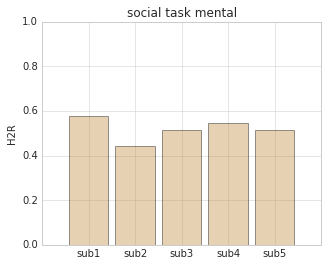

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.575279,0.440498,0.51323,0.545709,0.516459


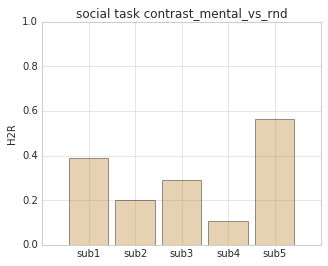

Subt,sub1,sub2,sub3,sub4,sub5
H2R,0.390694,0.202039,0.289739,0.108292,0.565559


In [63]:
## Loop over trait and create heritability table for radar plot
#list_trial = [xx.replace('-','_') for xx in list_trial]
list_sbt = ['sub1','sub2','sub3','sub4','sub5']
for trait_herit in list_trial:
    mask_df = [x[4:-10] == trait_herit for x in out_herit_df_clean.Trait.str.strip()]
    out_herit_select = out_herit_df_clean[['Trait','H2r']][mask_df]
    # extract trial
    column_net = [' '.join(row['Trait'].split('_')[0:-2]) for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Trial'] = column_net
    # extract subtype
    column_subt = [row['Trait'].split('_')[-2].strip() for ind,row in out_herit_select[['Trait']].iterrows()]
    out_herit_select.loc[:,'Subt'] = column_subt
    out_herit_clean = out_herit_select[['Trial','Subt','H2r']]
    # Pivot table
    out_herit_final = out_herit_clean.pivot(index='Trial',columns='Subt',values='H2r')
    out_herit_final.index.name=None
    out_herit_final.rename(index={column_net[1]: 'H2R'},inplace= True)
    #put 0 for non for empty heritabity
    for ii in list_sbt:
        if ii not in out_herit_final.columns.get_values():
            out_herit_final.loc[:,ii]=0
    out_herit_final=out_herit_final[list_sbt]
    out_herit_final.to_csv(os.path.join(out_path,solar_out,h2r_out_file.format(task_name,trait_herit)))
    # H2R bar plot
    fig,ax = plt.subplots(figsize=(5, 4))
    y_pos = np.arange(len(out_herit_final.columns))
    ax.bar(y_pos,out_herit_final.ix['H2R'],color="#c18c41",alpha=0.4,align = 'center',width=0.85)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(list_sbt)
    ax.set_ylim(0,1)
    ax.set_ylabel('H2R')
    #ax.grid(False)
    plt.title('{} task {}'.format(task_name,trait_herit))
    plt.show()
    fig.savefig(os.path.join(subt_path,"{}_barplot_heritability.svg".format(trait_herit)))
    display(out_herit_final)

In [64]:
##### R section #########

In [65]:
# first on terminal install cairo : "sudo apt install libcairo2-dev"
# devtools::install_github("hadley/svglite")
# devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)
import warnings
warnings.filterwarnings('ignore')

In [66]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

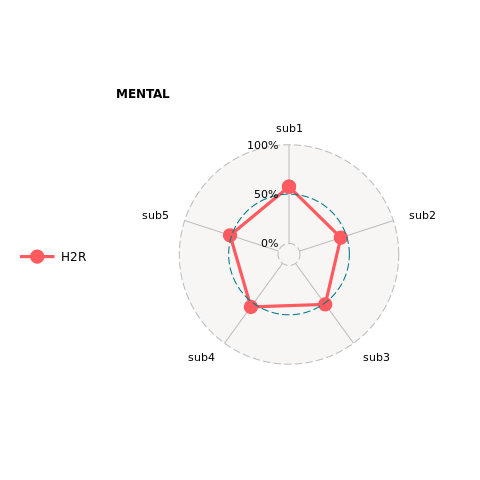

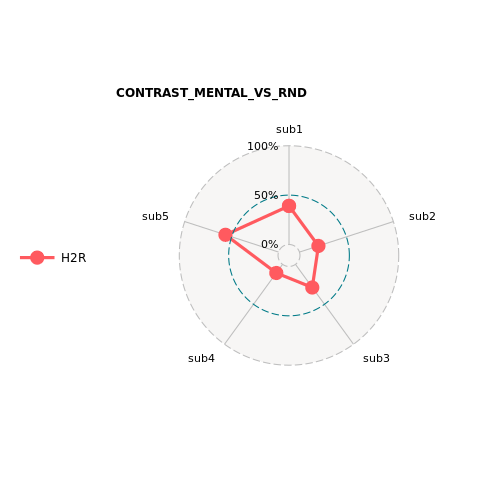

In [67]:
%%R -i out_path,solar_out,task_name,list_trial,path_root
for (ii in list_trial) {
    MyData <- read.csv(file=paste(out_path,solar_out,"/h2r_solar_",task_name,'_spm_',ii,'.csv',sep = ''))
    # plot radar 
    image=ggradar(MyData, grid.min = 0,
                  grid.mid = 0.5, 
                  grid.max = 1, 
                  axis.label.size = 4, 
                  grid.label.size = 5 ,
                  legend.text.size =5) +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' \n  ',toupper(ii),sep = ''))
    ggsave(file=paste(path_root,"subtypes_scores/26-10-2016/subtype_5_spm_SOCIAL_18-Oct-2017/" ,ii,"_heritability.svg",sep = ''), plot=image, width=10, height=8)
    print(image)
     }